In [1]:
import matplotlib.pyplot as plt
# from erddapClient import ERDDAP_Griddap
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import cmocean

from mpl_toolkits.basemap import Basemap
from matplotlib import colors

In [24]:
# Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, L4 (monthly and interpolated) from Satellite Observations (Near Real Time)
file_id = Dataset('/home/jamie/projects/climate/data/chl/derived/chla_stl_slope_20250326.nc')
ras = file_id.variables["CHL"][:]
#mask = file_id.variables["mask"][:]
lat = file_id.variables["latitude"][:]
lon = file_id.variables["longitude"][:]
file_id.close()

pvals = ras[1,:,:]
slopes = ras[0,:,:]

sig_slopes = slopes.copy()
sig_mask = pvals > 0.05
sig_slopes[sig_mask] = 0

# convert to xarray. 
sig_slopes = xr.DataArray(sig_slopes,
                          coords={'x': lat, 'y':lon}, 
                          dims=["x", "y"])

# fudging the nubers to get the colormap nice. 
# ras_colorbar = ras.clip(min = 0, max = 0.012, keep_attrs=False)

# Dont forget this step....
sig_slopes.data = sig_slopes.data * 365
# sig_slopes = sig_slopes.clip(min = -0.003, max = 0.004, keep_attrs=False)
sig_slopes = sig_slopes.clip(min = -0.0021, max = 0.0021, keep_attrs=False)

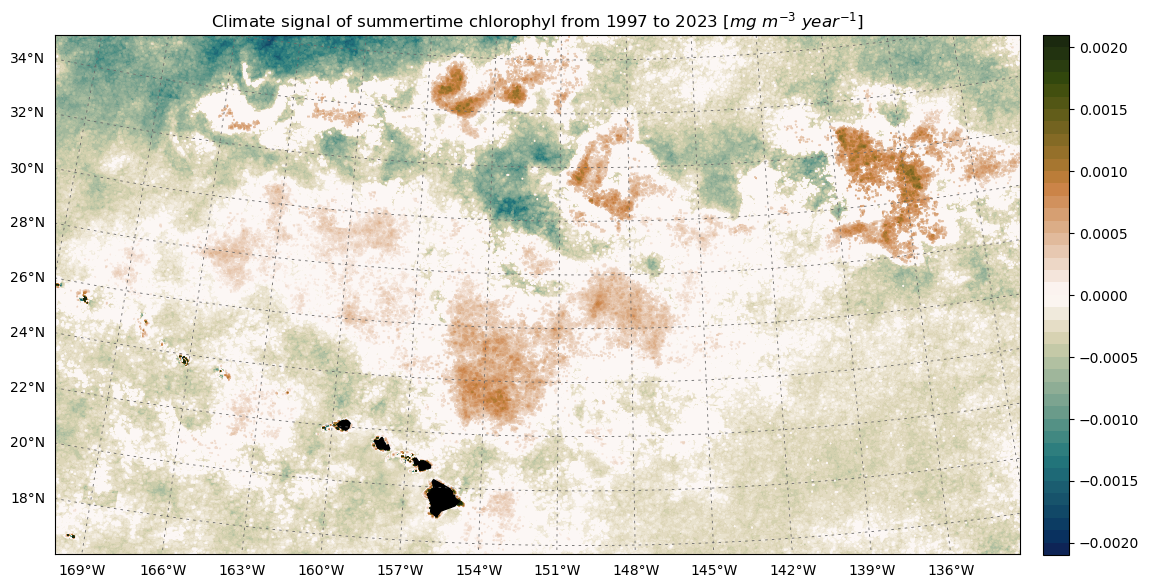

In [25]:
divnorm = colors.TwoSlopeNorm(vmin = np.nanmin(sig_slopes.data), vcenter = 0, vmax = np.nanmax(sig_slopes.data))

# Calculate the bounds of the data
lon_bounds = [sig_slopes.y.min(), sig_slopes.y.max()]
lat_bounds = [sig_slopes.x.min(), sig_slopes.x.max()]

fig, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
m = Basemap(projection='lcc', resolution='l', 
            llcrnrlat=16, urcrnrlat=35.5, 
            llcrnrlon=-170, urcrnrlon=-130,
            lat_0 = 30, lon_0 = -150,
            width=5.1E6, height=5E6)

# Convert latitude and longitude to map projection coordinates.
x_map, y_map = np.meshgrid(sig_slopes.y, sig_slopes.x)
x, y = m(x_map, y_map)
# Plot data.
contour = m.contourf(x, y, sig_slopes, cmap = cmocean.cm.tarn_r, levels=100, extend='both', norm=divnorm)
m.fillcontinents(color = 'black')
# Add grid lines
parallels = m.drawparallels(np.arange(18, 40, 2), labels=[1,0,0,0], textcolor = 'black', color = "dimgrey", fontsize=10, dashes=(3, 5), linewidth = 0.6)
meridians =  m.drawmeridians(np.arange(-175, -130, 3), labels=[0,0,0,1], textcolor = 'black', color = "dimgrey", fontsize=10, dashes=(3, 5),linewidth = 0.6)
# Draw parallels and meridians with customized gridline alpha and label colors
m.drawcoastlines(color='black')
# add colorbar.
c = ax1.contourf(sig_slopes.y, sig_slopes.x, sig_slopes, levels = 50, cmap = cmocean.cm.tarn_r, norm=divnorm)
cbar = fig.colorbar(c, shrink = 0.965, pad = 0.02)
plt.title("Climate signal of summertime chlorophyl from 1997 to 2023 [$mg$ $m^{-3}$ $year^{-1}$]")
# plt.savefig('../../figures/bloom_slope_chl_20250320.png', bbox_inches='tight', dpi=300)
plt.show()